# 📊 Exploratory Data Analysis (EDA)


## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load data
train = pd.read_csv(r'D:\Topic_13_Project\Topic_13_Retail_Store_Sales_Time_Series\data\processed\train_cleaned.csv', parse_dates=['date'])
print(f"Data shape: {train.shape}")
print(f"Date range: {train['date'].min()} to {train['date'].max()}")

Data shape: (3000888, 6)
Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00


## 2. Outlier Detection & Handling

Outliers detected: 0 days (0.00%)
Lower bound: $-586,990
Upper bound: $1,815,647


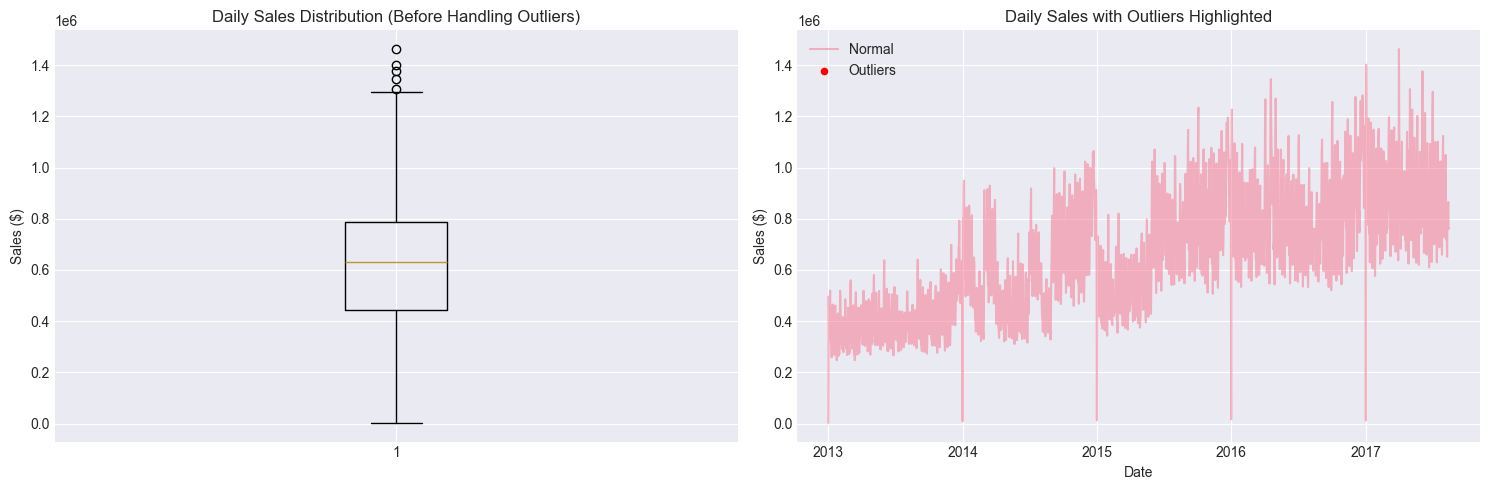


Original sales range: $2,512 - $1,463,084
Capped sales range: $2,512 - $1,463,084


In [3]:
# Aggregate daily total sales
daily_sales = train.groupby('date')['sales'].sum().reset_index()
daily_sales = daily_sales.sort_values('date')

# Outlier detection using IQR method
Q1 = daily_sales['sales'].quantile(0.25)
Q3 = daily_sales['sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR  # Using 3*IQR for more conservative approach
upper_bound = Q3 + 3 * IQR

# Identify outliers
daily_sales['is_outlier'] = (daily_sales['sales'] < lower_bound) | (daily_sales['sales'] > upper_bound)
outlier_count = daily_sales['is_outlier'].sum()

print(f"Outliers detected: {outlier_count} days ({outlier_count/len(daily_sales)*100:.2f}%)")
print(f"Lower bound: ${lower_bound:,.0f}")
print(f"Upper bound: ${upper_bound:,.0f}")

# Visualize outliers before handling
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Box plot
axes[0].boxplot(daily_sales['sales'])
axes[0].set_title('Daily Sales Distribution (Before Handling Outliers)')
axes[0].set_ylabel('Sales ($)')

# Time series with outliers marked
axes[1].plot(daily_sales['date'], daily_sales['sales'], alpha=0.5, label='Normal')
axes[1].scatter(daily_sales[daily_sales['is_outlier']]['date'], 
                daily_sales[daily_sales['is_outlier']]['sales'], 
                color='red', s=20, label='Outliers', zorder=5)
axes[1].set_title('Daily Sales with Outliers Highlighted')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Sales ($)')
axes[1].legend()
plt.tight_layout()
plt.show()

# Strategy: Cap outliers instead of removing (preserve data points for business context)
daily_sales['sales_capped'] = daily_sales['sales'].clip(lower=lower_bound, upper=upper_bound)

# Keep original for comparison but use capped version for most analysis
print(f"\nOriginal sales range: ${daily_sales['sales'].min():,.0f} - ${daily_sales['sales'].max():,.0f}")
print(f"Capped sales range: ${daily_sales['sales_capped'].min():,.0f} - ${daily_sales['sales_capped'].max():,.0f}")

## 3. Data Aggregation

### Sales by time periods ( Monthly, Yearly )

In [4]:
# Use capped sales for aggregation
daily_sales['year'] = daily_sales['date'].dt.year
daily_sales['month'] = daily_sales['date'].dt.month
daily_sales['quarter'] = daily_sales['date'].dt.quarter
daily_sales['day_of_week'] = daily_sales['date'].dt.dayofweek
daily_sales['week'] = daily_sales['date'].dt.isocalendar().week

# Monthly aggregation
monthly_sales = daily_sales.groupby([daily_sales['date'].dt.to_period('M')])['sales_capped'].agg([
    ('total_sales', 'sum'),
    ('avg_sales', 'mean'),
    ('std_sales', 'std')
]).reset_index()
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

# Quarterly aggregation
quarterly_sales = daily_sales.groupby([daily_sales['date'].dt.to_period('Q')])['sales_capped'].agg([
    ('total_sales', 'sum'),
    ('avg_sales', 'mean')
]).reset_index()
quarterly_sales['date'] = quarterly_sales['date'].dt.to_timestamp()

# Yearly aggregation
yearly_sales = daily_sales.groupby('year')['sales_capped'].agg([
    ('total_sales', 'sum'),
    ('avg_sales', 'mean')
]).reset_index()

# Growth rates
monthly_sales['mom_growth'] = monthly_sales['total_sales'].pct_change() * 100
yearly_sales['yoy_growth'] = yearly_sales['total_sales'].pct_change() * 100

print("Monthly Sales Summary:")
print(monthly_sales.head())
print("\nYearly Growth:")
print(yearly_sales)

Monthly Sales Summary:
        date   total_sales      avg_sales      std_sales  mom_growth
0 2013-01-01  1.032762e+07  333149.185062  100236.429008         NaN
1 2013-02-01  9.658960e+06  344962.849194   71232.006925   -6.474528
2 2013-03-01  1.142850e+07  368661.194758   88307.558055   18.320164
3 2013-04-01  1.099346e+07  366448.824600   75913.184475   -3.806557
4 2013-05-01  1.159770e+07  374119.484098   82202.776404    5.496350

Yearly Growth:
   year   total_sales      avg_sales  yoy_growth
0  2013  1.404190e+08  385766.521757         NaN
1  2014  2.094742e+08  575478.698631   49.177978
2  2015  2.408801e+08  661758.518282   14.992704
3  2016  2.886545e+08  790834.309463   19.833279
4  2017  1.942171e+08  855581.799001  -32.716430


## 4. Visualization

### I. Overall Trend


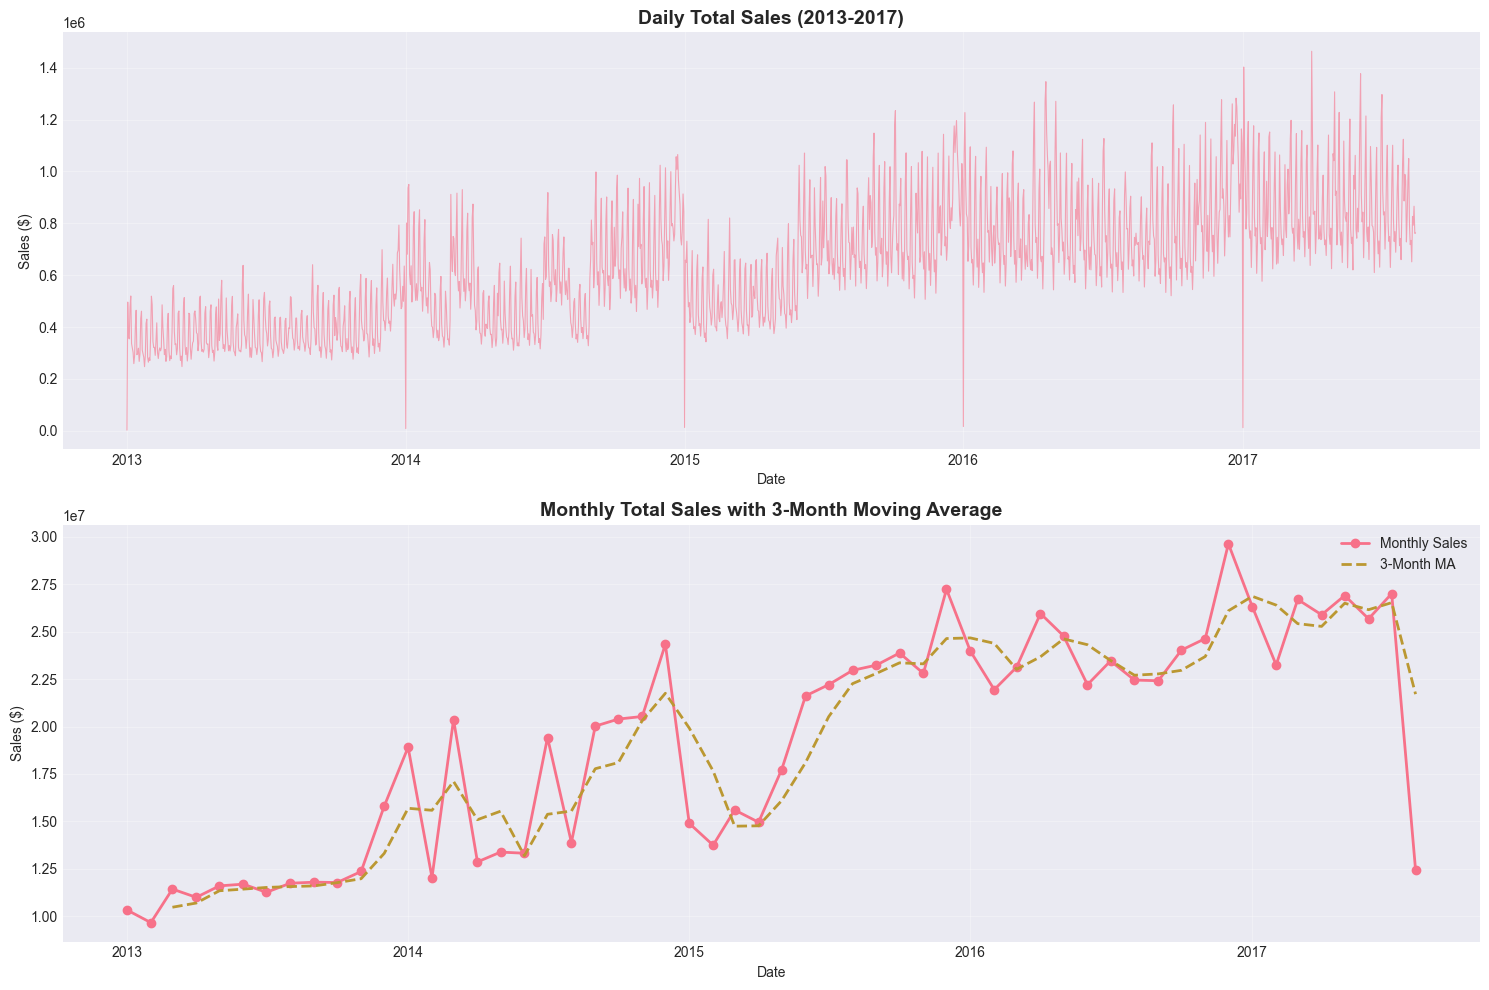

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Daily sales trend
axes[0].plot(daily_sales['date'], daily_sales['sales_capped'], alpha=0.6, linewidth=0.8)
axes[0].set_title('Daily Total Sales (2013-2017)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales ($)')
axes[0].grid(True, alpha=0.3)

# Monthly sales with moving average
axes[1].plot(monthly_sales['date'], monthly_sales['total_sales'], marker='o', linewidth=2, label='Monthly Sales')
axes[1].plot(monthly_sales['date'], monthly_sales['total_sales'].rolling(3).mean(), 
             linewidth=2, linestyle='--', label='3-Month MA')
axes[1].set_title('Monthly Total Sales with 3-Month Moving Average', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Sales ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### II. Seasonal Decomposition

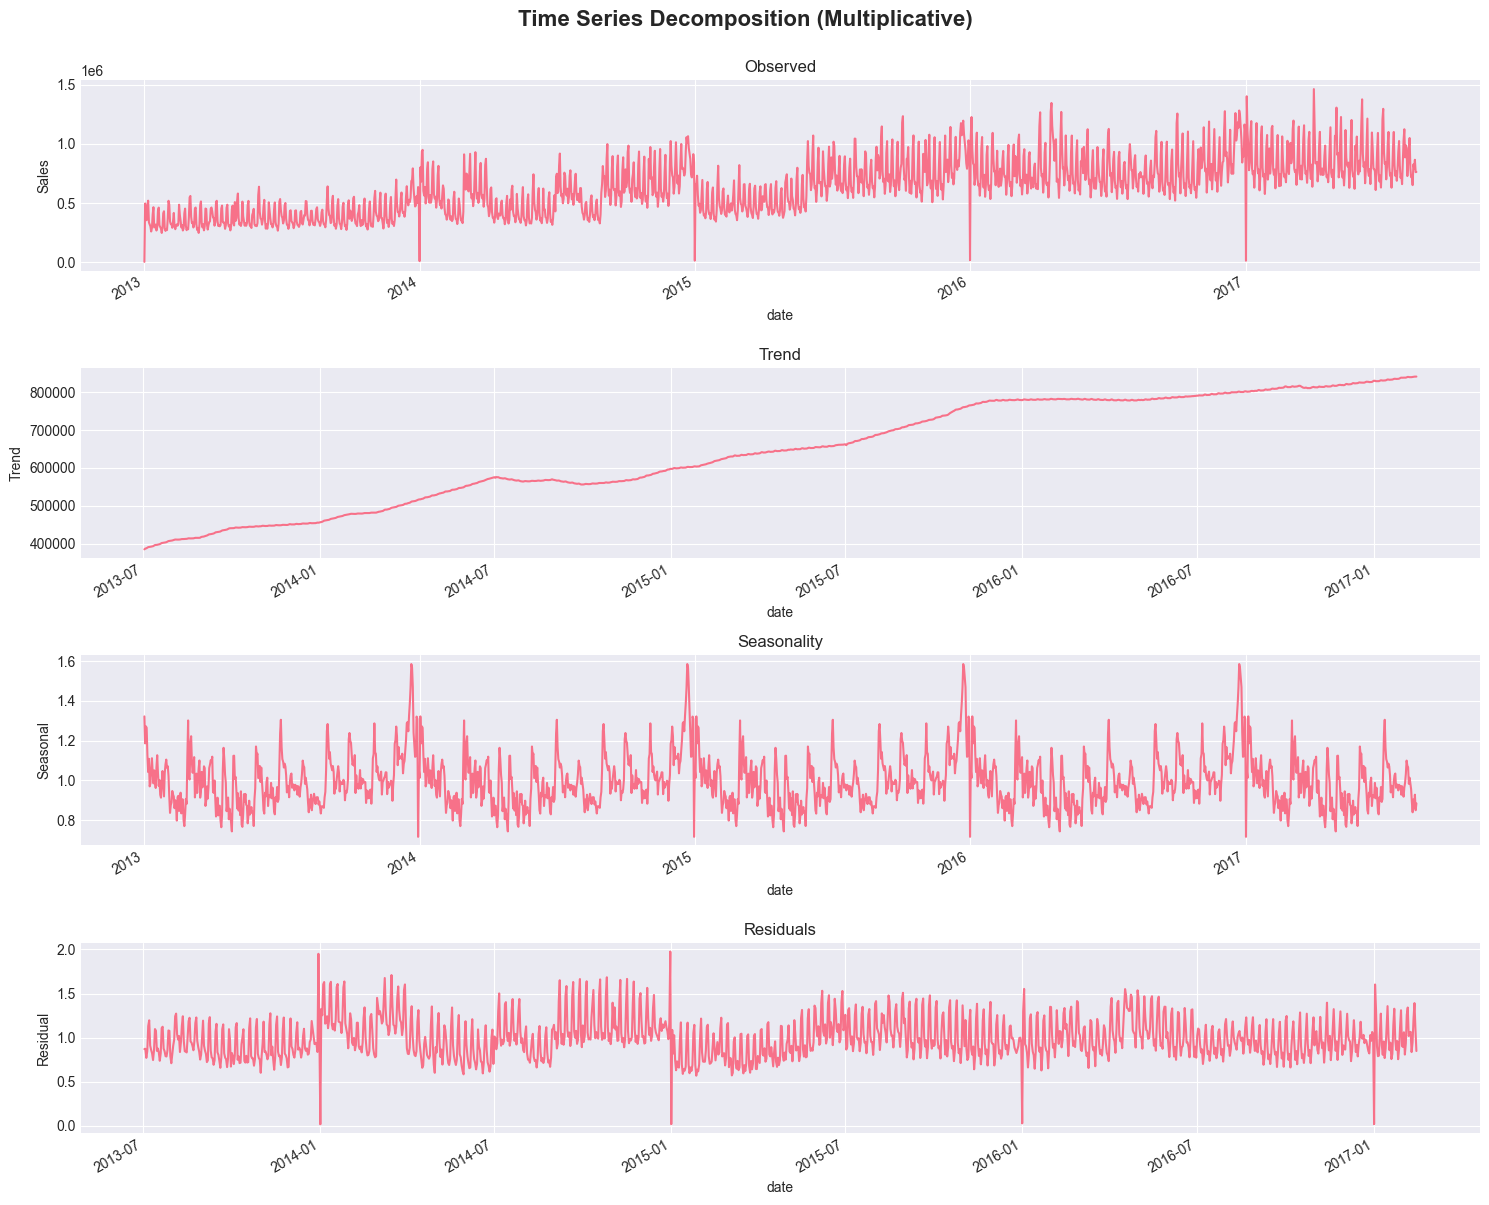

In [6]:
# Prepare data for decomposition (need regular frequency)
daily_ts = daily_sales.set_index('date')['sales_capped']

# Decompose with multiplicative model (better for sales data)
decomposition = seasonal_decompose(daily_ts, model='multiplicative', period=365)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

decomposition.observed.plot(ax=axes[0], title='Observed')
axes[0].set_ylabel('Sales')

decomposition.trend.plot(ax=axes[1], title='Trend')
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], title='Seasonality')
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], title='Residuals')
axes[3].set_ylabel('Residual')

plt.suptitle('Time Series Decomposition (Multiplicative)', fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

### III. Seasonality Heatmap

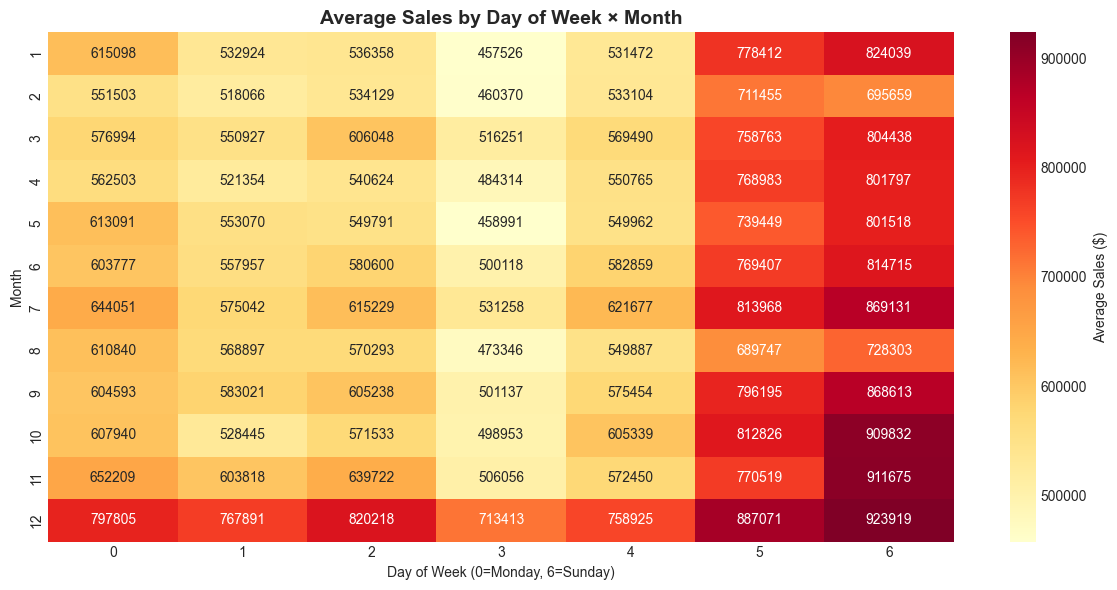

In [7]:
# Create day of week x month heatmap
pivot_data = daily_sales.groupby(['month', 'day_of_week'])['sales_capped'].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Average Sales ($)'})
plt.title('Average Sales by Day of Week × Month', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

### IV. Monthly & Quarterly Patterns

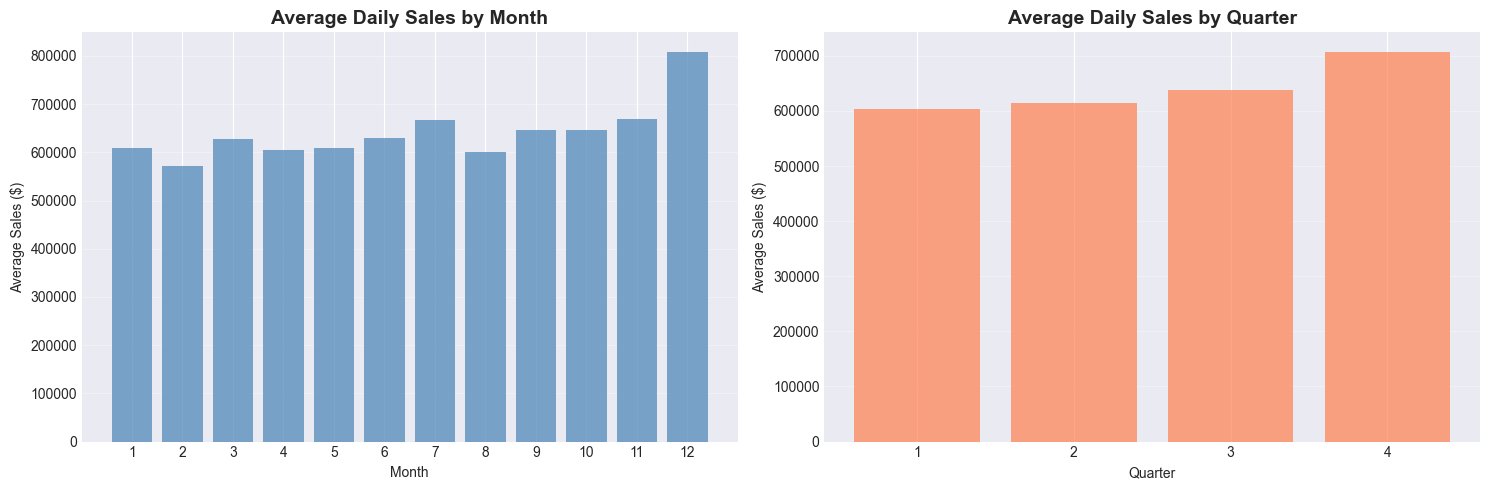

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Average sales by month
monthly_avg = daily_sales.groupby('month')['sales_capped'].mean().sort_index()
axes[0].bar(monthly_avg.index, monthly_avg.values, color='steelblue', alpha=0.7)
axes[0].set_title('Average Daily Sales by Month', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Average Sales ($)')
axes[0].set_xticks(range(1, 13))
axes[0].grid(axis='y', alpha=0.3)

# Average sales by quarter
quarterly_avg = daily_sales.groupby('quarter')['sales_capped'].mean().sort_index()
axes[1].bar(quarterly_avg.index, quarterly_avg.values, color='coral', alpha=0.7)
axes[1].set_title('Average Daily Sales by Quarter', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Quarter')
axes[1].set_ylabel('Average Sales ($)')
axes[1].set_xticks(range(1, 5))
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### V. Year-over-Year Comparison

<Figure size 1400x600 with 0 Axes>

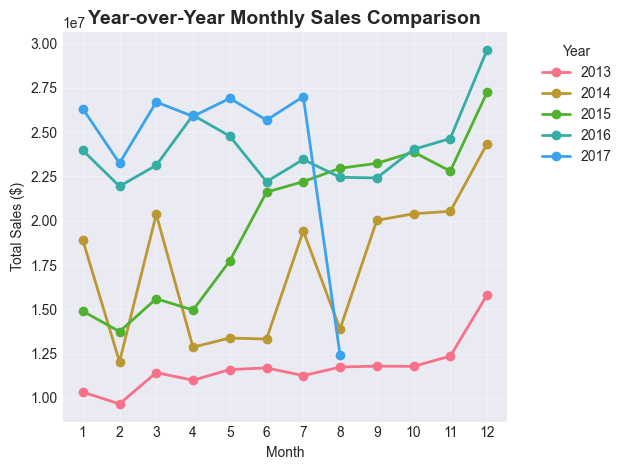

In [9]:
# Monthly sales by year
monthly_by_year = daily_sales.groupby(['year', 'month'])['sales_capped'].sum().unstack(level=0)

plt.figure(figsize=(14, 6))
monthly_by_year.plot(marker='o', linewidth=2)
plt.title('Year-over-Year Monthly Sales Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Total Sales ($)')
plt.xticks(range(1, 13))
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### VI. Distribution Analysis

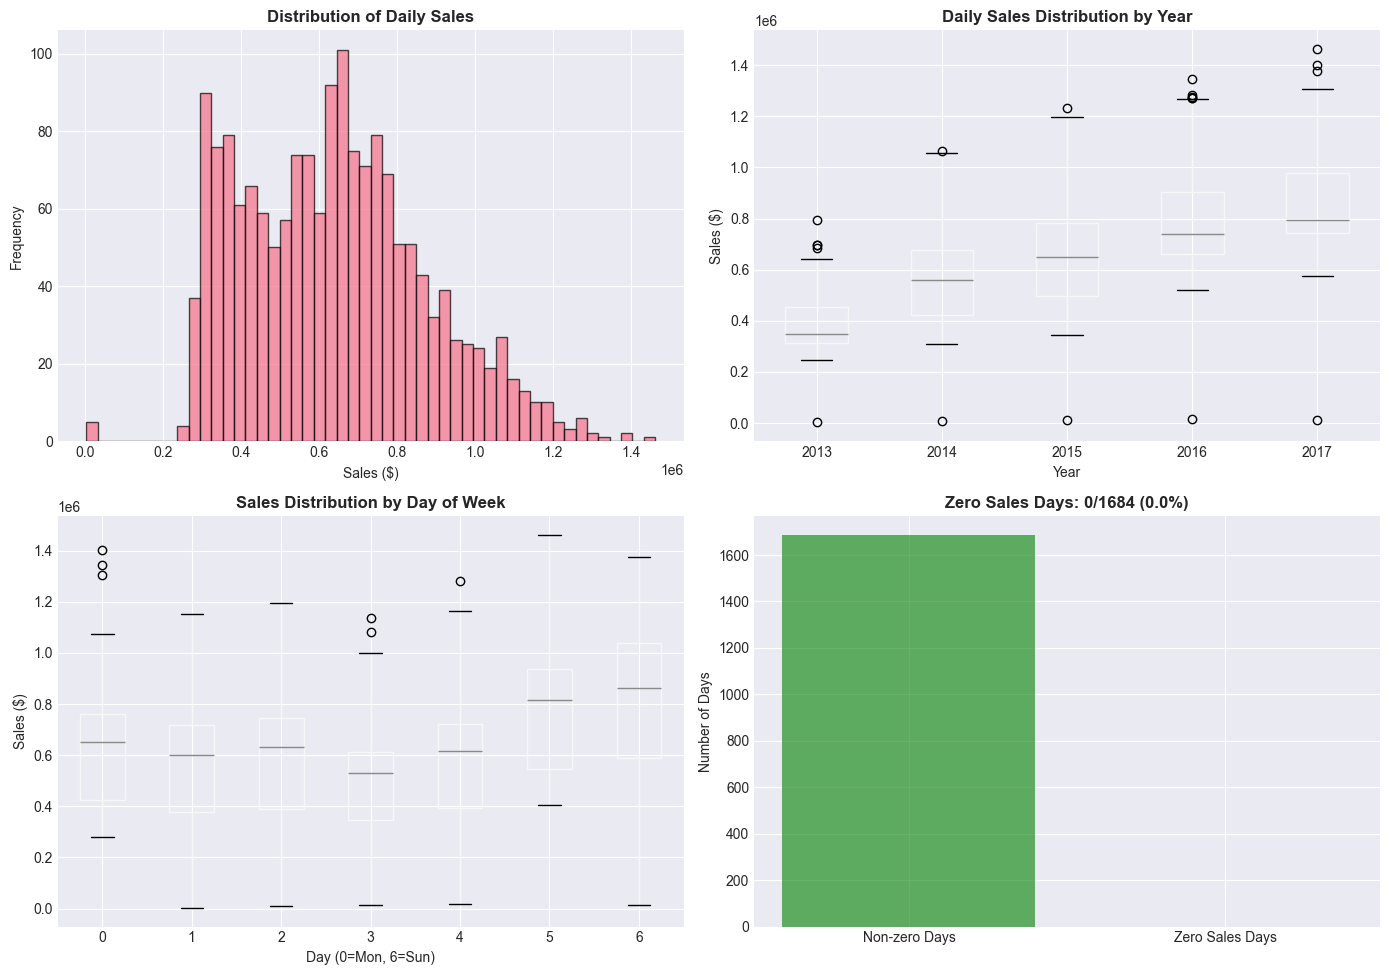

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram
axes[0, 0].hist(daily_sales['sales_capped'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Daily Sales', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Sales ($)')
axes[0, 0].set_ylabel('Frequency')

# Box plot by year
daily_sales.boxplot(column='sales_capped', by='year', ax=axes[0, 1])
axes[0, 1].set_title('Daily Sales Distribution by Year', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Sales ($)')
plt.sca(axes[0, 1])
plt.xticks(rotation=0)

# Day of week box plot
daily_sales.boxplot(column='sales_capped', by='day_of_week', ax=axes[1, 0])
axes[1, 0].set_title('Sales Distribution by Day of Week', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Day (0=Mon, 6=Sun)')
axes[1, 0].set_ylabel('Sales ($)')

# Zero sales analysis
zero_sales_daily = (train.groupby('date')['sales'].sum() == 0).sum()
total_days = len(daily_sales)
axes[1, 1].bar(['Non-zero Days', 'Zero Sales Days'], 
               [total_days - zero_sales_daily, zero_sales_daily],
               color=['green', 'red'], alpha=0.6)
axes[1, 1].set_title(f'Zero Sales Days: {zero_sales_daily}/{total_days} ({zero_sales_daily/total_days*100:.1f}%)', 
                     fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Number of Days')

plt.suptitle('')  # Remove auto-generated title
plt.tight_layout()
plt.show()

## 5. Metrics Summary

In [11]:
# Calculate key statistics
print("="*60)
print("KEY FINDINGS - OVERALL SALES TRENDS")
print("="*60)

# Overall trends
print("\n1. OVERALL GROWTH:")
print(f"   Total sales 2013: ${yearly_sales[yearly_sales['year']==2013]['total_sales'].values[0]:,.0f}")
print(f"   Total sales 2017: ${yearly_sales[yearly_sales['year']==2017]['total_sales'].values[0]:,.0f}")
print(f"   CAGR: {((yearly_sales[yearly_sales['year']==2017]['total_sales'].values[0] / yearly_sales[yearly_sales['year']==2013]['total_sales'].values[0]) ** (1/4) - 1) * 100:.2f}%")

# Seasonality
print("\n2. SEASONALITY PATTERNS:")
peak_month = monthly_avg.idxmax()
low_month = monthly_avg.idxmin()
print(f"   Peak month: {peak_month} (Avg: ${monthly_avg[peak_month]:,.0f}/day)")
print(f"   Lowest month: {low_month} (Avg: ${monthly_avg[low_month]:,.0f}/day)")

peak_quarter = quarterly_avg.idxmax()
print(f"   Peak quarter: Q{peak_quarter}")

# Day of week
dow_avg = daily_sales.groupby('day_of_week')['sales_capped'].mean()
peak_dow = dow_avg.idxmax()
low_dow = dow_avg.idxmin()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
print(f"   Best day: {days[peak_dow]} (Avg: ${dow_avg[peak_dow]:,.0f})")
print(f"   Slowest day: {days[low_dow]} (Avg: ${dow_avg[low_dow]:,.0f})")

# Volatility
print("\n3. VOLATILITY:")
print(f"   Daily sales std dev: ${daily_sales['sales_capped'].std():,.0f}")
print(f"   Coefficient of variation: {(daily_sales['sales_capped'].std() / daily_sales['sales_capped'].mean()) * 100:.2f}%")

# Data quality
print("\n4. DATA CHARACTERISTICS:")
zero_pct = (train['sales'] == 0).sum() / len(train) * 100
print(f"   Zero sales records: {zero_pct:.2f}% of all store-product-day combinations")
print(f"   Outliers detected: {outlier_count} days ({outlier_count/len(daily_sales)*100:.2f}%)")

print("\n" + "="*60)

KEY FINDINGS - OVERALL SALES TRENDS

1. OVERALL GROWTH:
   Total sales 2013: $140,419,014
   Total sales 2017: $194,217,068
   CAGR: 8.45%

2. SEASONALITY PATTERNS:
   Peak month: 12 (Avg: $808,565/day)
   Lowest month: 2 (Avg: $571,895/day)
   Peak quarter: Q4
   Best day: Sunday (Avg: $825,218)
   Slowest day: Thursday (Avg: $505,269)

3. VOLATILITY:
   Daily sales std dev: $234,410
   Coefficient of variation: 36.77%

4. DATA CHARACTERISTICS:
   Zero sales records: 31.30% of all store-product-day combinations
   Outliers detected: 0 days (0.00%)



In [13]:
median = daily_sales['sales_capped'].median()
print(f"Median daily sales after capping: ${median:,.0f}")

Median daily sales after capping: $632,189
